In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import pandas as pd

In [2]:
#数据加载
(image_train, label_train),\
(image_test, label_test) = mnist.load_data()

In [3]:
print('train data shape: ', image_train.shape)
print('train label shape: ', label_train.shape)
print('test data shape: ', image_test.shape)
print('test data shape: ', label_test.shape)

train data shape:  (60000, 28, 28)
train label shape:  (60000,)
test data shape:  (10000, 28, 28)
test data shape:  (10000,)


In [4]:
def plot_image(image):
    fig = plt.gcf()
    fig.set_size_inches(2, 2)
    plt.imshow(image, cmap='Greys')

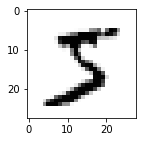

In [5]:
plot_image(image_train[0])

In [6]:
def plot_images_labels_predictions(images, labels, predictions, index_start, num = 10):
    index = index_start
    fig = plt.gcf()
    fig.set_size_inches(10, 12)
    for i in range(num):
        plt_sub = plt.subplot(5, 5, i+1)
        plt_sub.imshow(images[index], cmap='binary')
        title = 'label=' + str( labels[index] )
        if len(predictions) > 0:
            title += ', pred=' + str(predictions[index])
        plt_sub.set_title(title, fontsize=10)
        plt_sub.set_xticks([])
        plt_sub.set_yticks([])
        index += 1

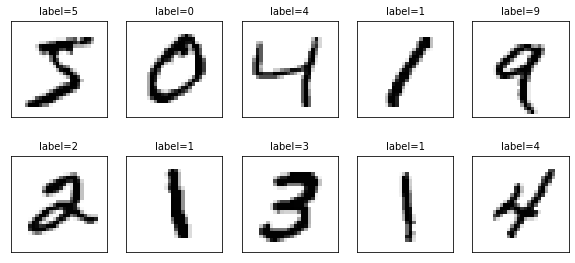

In [7]:
plot_images_labels_predictions(image_train, label_train, [], 0)

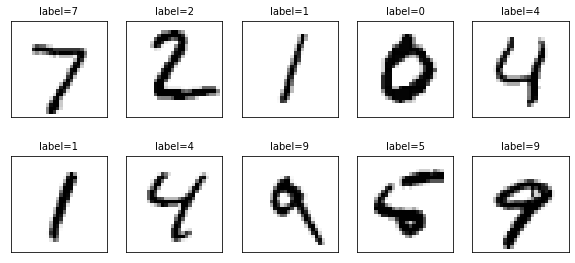

In [8]:
plot_images_labels_predictions(image_test, label_test, [], 0)

In [9]:
# 数据平坦化
image_train_flat = image_train.reshape(-1, 784)
image_test_flat = image_test.reshape(-1, 784)

In [10]:
#数据归一化
image_train_normalize = image_train_flat / 255
image_test_normalize = image_test_flat / 255

In [11]:
# One hot
print(label_train[0:10])

[5 0 4 1 9 2 1 3 1 4]


In [12]:
label_train_onehot = keras.utils.to_categorical(label_train)
label_test_onehot = keras.utils.to_categorical(label_test)
print(label_train_onehot[0:10])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [13]:
class MyDenseLayer(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        self.units = units
        self.activation = keras.layers.Activation(activation)
        super(MyDenseLayer, self).__init__( ** kwargs )
        
    def build(self, input_shape):
        # w * x + b   -> activation
        # input: [None, a] @ w:[a, b]  output: [None, b]
        self.my_weights = self.add_weight(name = 'my_weights',
                                          shape = (input_shape[1], self.units),
                                          initializer = 'normal',
                                          trainable = True)
        self.my_bias = self.add_weight(name = 'my_bias',
                                       shape = (self.units, ),
                                       initializer = 'zeros',
                                       trainable = True)
        super(MyDenseLayer, self).build(input_shape)
    
    def call(self, inputs):
        # Compute
        return self.activation( inputs @ self.my_weights + self.my_bias )

my_selu_layer = keras.layers.Lambda( lambda x: tf.nn.selu(x) )

In [14]:
# Create Model
model = keras.models.Sequential([
    MyDenseLayer(256, activation='relu', input_shape=(784,)),    
    keras.layers.Dense(10, activation='softmax')
])

#relu: max(0, x)
# softmax: 将向量变成概率分布 y = [e^x1/sum, e^x2/sum, e^x3/sum] -> [y1, y2, y3]
# sum = e^x1 + e^x2 + e^x3
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_dense_layer (MyDenseLayer (None, 256)               200960    
_________________________________________________________________
dense (Dense)                (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
# Compile model
# sparse_categorical_crossentropy ?
def my_metrics(y_label, y_pred):
    label_argmax = tf.argmax(y_label, axis=1)
    pred_argmax = tf.argmax(y_pred, axis=1)
    count = tf.shape( tf.where( label_argmax == pred_argmax ) )[0]
    total = tf.shape(y_label)[0]
    return count / total    
    
    #return keras.metrics.categorical_accuracy(y_label, y_pred)
    
#crossentropy: -sum( label * log(pred) )      mean()
def my_loss(y_true, y_pred):
    return tf.reduce_mean( -tf.reduce_sum( y_true * tf.math.log(y_pred), axis=1 ) )

class MyLoss(keras.losses.Loss):
    def call(self, y_true, y_pred):
        return my_loss(y_true, y_pred)

class MySGD(keras.optimizers.Optimizer):
    def __init__(self,
                 learning_rate=0.01,
                 name='MySGD',
                 **kwargs):
        super(MySGD, self).__init__(name, **kwargs)
        self._optimizer = keras.optimizers.SGD(lr=0.1)
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate))
        
    def _create_slots(self, var_list):
        pass
    
    def _resource_apply_dense(self, grad, var, apply_state=None):
        return self._optimizer._resource_apply_dense(grad, var)
    
    def get_config(self):
        config = super(MySGD, self).get_config()
        config.update({
            'learning_rate': self._serialize_hyperparameter("learning_rate")
        })
        return config

model.compile(loss = MyLoss(),
              optimizer = MySGD(),
              metrics = [my_metrics])

In [16]:
# Train
history = model.fit(image_train_normalize, label_train_onehot,
                    validation_split = 0.1, epochs=10, batch_size=200, verbose=2)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
54000/54000 - 2s - loss: 0.5564 - my_metrics: 0.8543 - val_loss: 0.2801 - val_my_metrics: 0.9203
Epoch 2/10
54000/54000 - 1s - loss: 0.3036 - my_metrics: 0.9146 - val_loss: 0.2234 - val_my_metrics: 0.9370
Epoch 3/10
54000/54000 - 2s - loss: 0.2538 - my_metrics: 0.9284 - val_loss: 0.1909 - val_my_metrics: 0.9470
Epoch 4/10
54000/54000 - 2s - loss: 0.2217 - my_metrics: 0.9379 - val_loss: 0.1724 - val_my_metrics: 0.9525
Epoch 5/10
54000/54000 - 2s - loss: 0.1966 - my_metrics: 0.9453 - val_loss: 0.1552 - val_my_metrics: 0.9603
Epoch 6/10
54000/54000 - 1s - loss: 0.1774 - my_metrics: 0.9499 - val_loss: 0.1405 - val_my_metrics: 0.9642
Epoch 7/10
54000/54000 - 1s - loss: 0.1614 - my_metrics: 0.9550 - val_loss: 0.1321 - val_my_metrics: 0.9657
Epoch 8/10
54000/54000 - 1s - loss: 0.1477 - my_metrics: 0.9589 - val_loss: 0.1236 - val_my_metrics: 0.9677
Epoch 

In [17]:
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.xlabel('Epoch')
    plt.ylabel(train)
    plt.legend(['train', 'validation'], loc='best')

show_train_history(history, 'categorical_accuracy','val_categorical_accuracy')  

KeyError: 'categorical_accuracy'

In [ ]:
show_train_history(history, 'loss', 'val_loss')

In [ ]:
model.evaluate(image_test_normalize, label_test_onehot, verbose=2)

In [ ]:
#Predict
pred = model.predict_classes(image_test_normalize)

In [ ]:
print(pred[0:10])

In [ ]:
plot_images_labels_predictions(image_test, label_test, pred, index_start=0)

In [ ]:
#错误数据分析
pd.crosstab(label_test, pred, rownames=['label'], colnames=['predict'])

In [ ]:
df = pd.DataFrame({'label':label_test, 'predict':pred})
df[:10]

In [ ]:
df[(df.label==5)&(df.predict==3)]

In [ ]:
plot_images_labels_predictions(image_test, label_test, pred, index_start=340, num=1)

In [ ]:
df[(df.label==9)&(df.predict==4)]

In [ ]:
plot_images_labels_predictions(image_test, label_test, pred, index_start=9587, num=1)